# Poly Prep
Cascade Tuholske Dec 2020


In [53]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt

In [2]:
# file paths 
data_in = '/Users/cascade/Github/PopGridCompare/data/raw/'
data_out = '/Users/cascade/Github/PopGridCompare/data/interim/'

## dissolve polygons for Mozambique, Zimbabwe & Malawai 

In [3]:
# polys in
zwe = gpd.read_file(data_in+'GDAM/gadm36_ZWE_shp/gadm36_ZWE_0.shp')
mwi = gpd.read_file(data_in+'GDAM/gadm36_MWI_shp/gadm36_MWI_0.shp')
moz = gpd.read_file(data_in+'GDAM/gadm36_MOZ_shp/gadm36_MOZ_0.shp')

In [4]:
dfs = [zwe, mwi, moz]
polys = gpd.GeoDataFrame(pd.concat(dfs))

,GID_0,NAME_0,geometry
0,ZWE,Zimbabwe,"POLYGON ((31.05947 -22.33982, 31.05900 -22.339..."
0,MWI,Malawi,"MULTIPOLYGON (((34.75042 -12.06486, 34.75042 -..."
0,MOZ,Mozambique,"MULTIPOLYGON (((32.88820 -26.28681, 32.88820 -..."


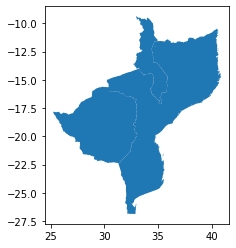

In [5]:
polys.plot()
polys.head()

In [6]:
# Dissolve 
polys['ID'] = 'M-M-Z'
diss = polys.dissolve(by = 'ID')

<AxesSubplot:>

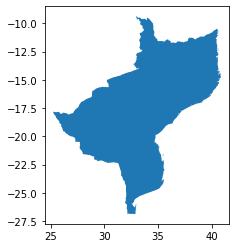

In [7]:
diss.plot()

In [8]:
# write
diss.to_file(data_out+'M-M-Z.shp')

## Drop Islands for Ecuador

In [71]:
# polys in
ecu = gpd.read_file(data_in+'GDAM/gadm36_ECU_shp/gadm36_ECU_0.shp')
flood = gpd.read_file(data_in+'ECU-Floods/Susceptibility/FF_suscept_PCA.shp')
fn_out = data_out+'ECU-clip.shp'

In [47]:
# change crs
flood = flood.to_crs(ecu.crs)

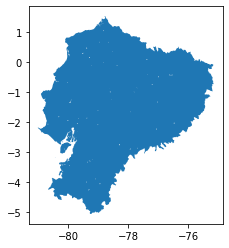

In [48]:
# dissolve floods and get bounding box
flood['ID'] = 'ECU'
diss = flood.dissolve(by = 'ID')
diss.plot()
bb = box(*diss.total_bounds)

In [64]:
# make bb a geodata frame
df = pd.DataFrame(['ECU'])
df['geometry'] = bb
bb_gdf = gpd.GeoDataFrame(df).buffer(1)

<AxesSubplot:>

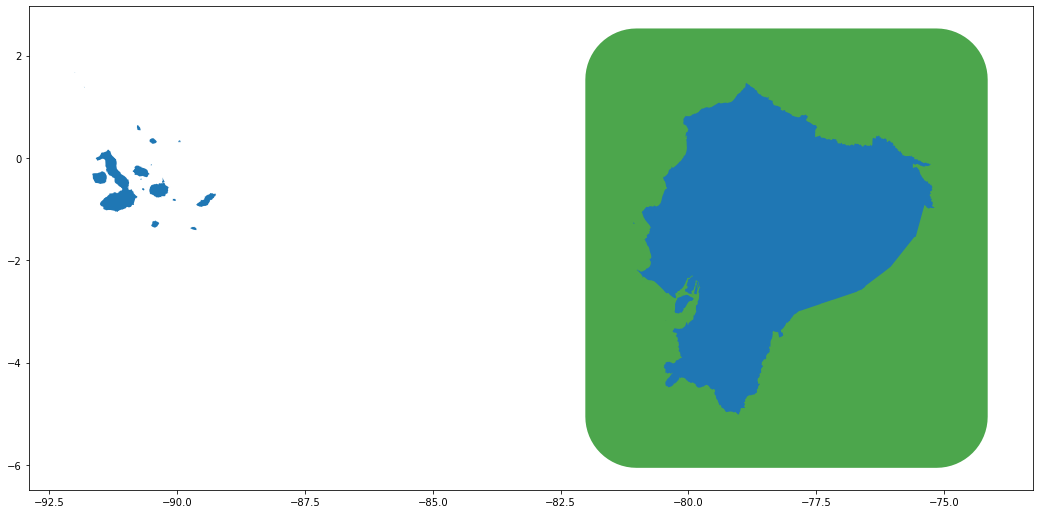

In [65]:
# plot them

axs = bb_gdf.plot(color = 'green', alpha = 0.7, figsize = (18, 18))
ecu.plot(ax = axs, figsize = (8, 8))

In [68]:
bb_gdf.crs

<ipython-input-70-5890facbf9ad>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  clip = gpd.clip(ecu, bb_gdf)


<AxesSubplot:>

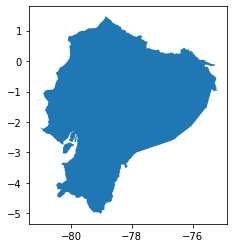

In [70]:
# clip to buffer (will throw warning; that's ok)
clip = gpd.clip(ecu, bb_gdf)
clip.plot()

In [72]:
clip.to_file(fn_out)